# Age Stratified Model

This notebook demonstrates how to construct a multi-season age stratified model.

In [1]:
# Add graphviz to path
import os

os.environ["PATH"] = os.environ["PATH"] + ":/opt/homebrew/bin"

# stdlib dependencies
import pathlib

# External dependency imports
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.special import expit
import seaborn as sns

# `vaxflux` imports
from vaxflux.multilevel_model import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


TODO: Discuss the dataset some

In [2]:
with pathlib.Path(
    "~/Documents/vacc_alldoses_age_Flu_2024_R1_allflu_allseasons.csv"
).expanduser().open() as f:
    vacc_df = pd.read_csv(f)

columns = vacc_df.columns.tolist()
vacc_df["name"] = vacc_df["NAME"].astype("string")
vacc_df = vacc_df[["name"] + columns[1:]]
vacc_df["end_date"] = pd.to_datetime(vacc_df["end_date"])
vacc_df["age_group"] = vacc_df["age_group"].astype("string")
vacc_df["USPS"] = vacc_df["USPS"].astype("string")
vacc_df["start_date"] = pd.to_datetime(vacc_df["start_date"])
vacc_df["dose"] = vacc_df["dose"].astype("string")
vacc_df["scenario"] = vacc_df["scenario"].astype("string")
vacc_df["date"] = pd.to_datetime(vacc_df["date"])
vacc_df["date_admin"] = pd.to_datetime(vacc_df["date_admin"])
vacc_df["season"] = vacc_df["season"].astype("string")
vacc_df["seasonid"] = vacc_df["seasonid"].astype("string")

subset_vacc_df = vacc_df[["season", "USPS", "age_group", "date", "prop_vacc_age"]]
subset_vacc_df.columns = ["season", "region", "strata", "time", "rate"]
subset_vacc_df = subset_vacc_df[subset_vacc_df["region"] == "NC"]

subset_vacc_df

,season,region,strata,time,rate
5535,2010-11,NC,0_4,2010-08-28,0.0000
5536,2010-11,NC,0_4,2010-09-04,0.0608
5537,2010-11,NC,0_4,2010-09-11,0.0650
5538,2010-11,NC,0_4,2010-09-18,0.0776
5539,2010-11,NC,0_4,2010-09-25,0.0963
...,...,...,...,...,...
141416,2023-24,NC,65_100,2024-05-05,0.7030
141417,2023-24,NC,65_100,2024-05-12,0.7030
141418,2023-24,NC,65_100,2024-05-19,0.7030
141419,2023-24,NC,65_100,2024-05-26,0.7030


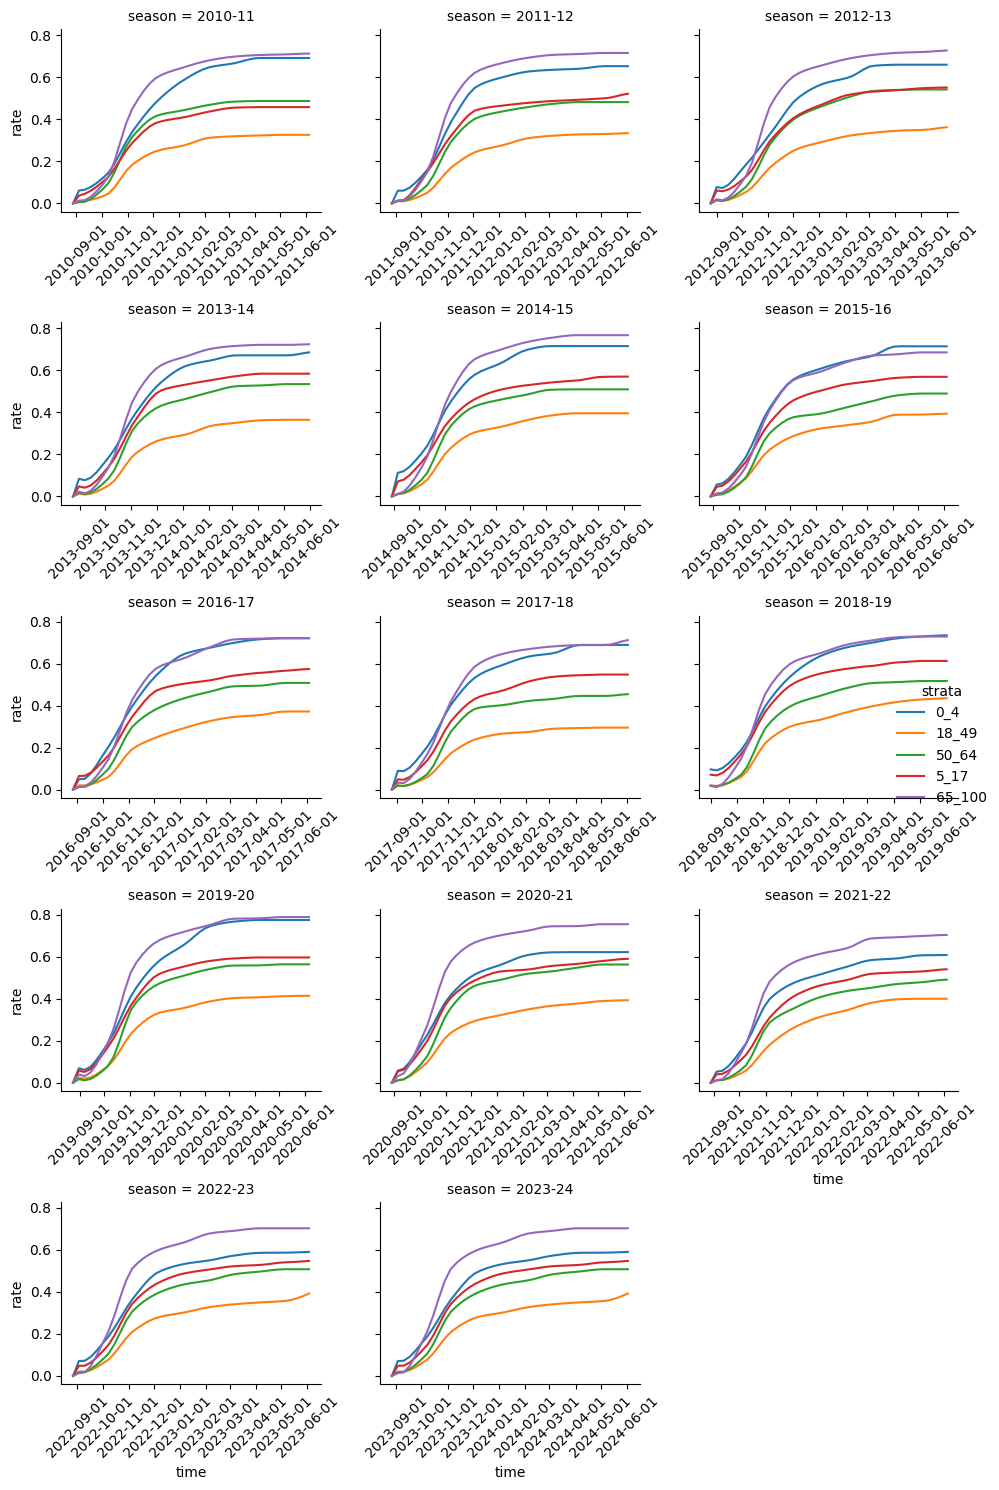

In [3]:
g = sns.FacetGrid(
    data=subset_vacc_df, col="season", hue="strata", col_wrap=3, sharex=False
)
g.map(sns.lineplot, "time", "rate")
g.set_xticklabels(rotation=45)
g.add_legend()
plt.tight_layout()
plt.show()

## The Model

The model being used here will be largely based on the one from the `multiseason_model.ipynb` notebook. Let $i=1,\dots,N_{\mathrm{seasons}}$ and $j=1,\dots,N_{\mathrm{strata}}$, then

$$ k_i \sim \mathcal{N}\left( \mu_k, \sigma_k^2 \right) $$

$$ r \sim \mathcal{N}\left( \mu_r, \sigma_r^2 \right) $$

$$ s \sim \mathcal{N}\left( \mu_s, \sigma_s^2 \right) $$

$$ \delta k_j \sim \mathcal{N}\left( \mu_{\delta k_{\mathrm{strata}}}, \sigma_{\delta k_{\mathrm{strata}}}^2 \right) $$

$$ \delta r_j \sim \mathcal{N}\left( \mu_{\delta r_{\mathrm{strata}}}, \sigma_{\delta r_{\mathrm{strata}}}^2 \right) $$

$$ \delta s_j \sim \mathcal{N}\left( \mu_{\delta s_{\mathrm{strata}}}, \sigma_{\delta s_{\mathrm{strata}}}^2 \right) $$

$$ \epsilon \sim \mathrm{HalfNormal}\left( \epsilon_{\mathrm{prior}} \right) $$

$$ y_{ij}(t) \sim \mathcal{N}\left( f\left( t \vert K_{ij}, r + \delta r_j, s + \delta s_j \right), \epsilon^2 \right) $$

where $K_{ij} = \left( 1 + e^{-\left(k_i + \delta k_j\right)} \right)^{-1}$ and $f(t\vert k,r,s)$ is a logistic function given by

$$ f\left( t \vert k, r ,s \right) = \frac{k}{1 + e^{-r(t - s)}}. $$

## Constructing The Model With `vaxflux`

Now to build this model using `vaxflux` the first step is to construct an `UptakeModelConfig` object that describes this model. The priors for $k_i$, $r$, and $s$ are mildly informative whereas the priors for $\delta k_j$, $\delta r_j$, and $\delta s_j$ are strongly informative. The reason being it is preferable for comparison purposes that the model attempt to explain more of the variance using the non-strata parameters.

In [4]:
# Construct a DataFrame of season starts
season_starts = pd.DataFrame(
    data=[
        {"season": f"20{i}-{i+1}", "start_time": f"20{i}-08-15"} for i in range(10, 24)
    ]
)
season_starts["season"] = season_starts["season"].astype("string")
season_starts["start_time"] = pd.to_datetime(season_starts["start_time"])

# Merge and make calculation
data_df = subset_vacc_df.merge(season_starts, on="season")
data_df["time"] = (data_df["time"] - data_df["start_time"]).dt.days
data_df = data_df.drop(columns=["start_time"])

In [5]:
uptake_config = UptakeModelConfig(
    name="Multi-Season Age Stratified Uptake Model For NC",
    data=data_df,
    eps_prior=0.1,
    k_prior=(0.0, 0.5),
    r_prior=(0.5, 0.25),
    s_prior=(30.0, 6.0),
    dk_strata_prior=(0.0, 0.5),
    dr_strata_prior=(0.0, 0.05),
    ds_strata_prior=(0.0, 1.0),
)
uptake_config

<vaxflux.multilevel_model.UptakeModelConfig named 'Multi-Season Age Stratified Uptake Model For NC'>

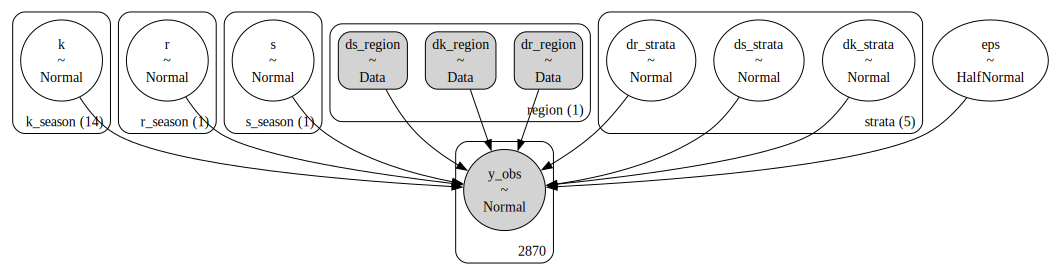

In [6]:
model = create_multilevel_model(uptake_config)
pm.model_to_graphviz(model)

TODO: Discuss the model

## Sampling The Model 

The next thing to do is to sample from the model and then evaluate how well it performs.

In [8]:
chains = 2
samples = 1000 * chains
with model:
    trace = pm.sample(
        draws=samples, tune=samples, chains=chains, cores=2, random_seed=123
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k, r, s, dk_strata, dr_strata, ds_strata, eps]


/Users/twillard/Library/Caches/pypoetry/virtualenvs/vaxflux-TxTkjOEN-py3.12/lib/python3.12/site-packages/rich/live.
py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 202 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [9]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
dk_strata[0_4],0.614,0.115,0.397,0.826,0.005,0.004,468.0,610.0,1.0
dk_strata[18_49],-0.663,0.115,-0.873,-0.447,0.005,0.004,468.0,595.0,1.0
dk_strata[50_64],-0.093,0.115,-0.296,0.134,0.005,0.004,469.0,604.0,1.0
dk_strata[5_17],0.107,0.115,-0.094,0.336,0.005,0.004,471.0,605.0,1.0
dk_strata[65_100],0.811,0.115,0.610,1.039,0.005,0.004,468.0,605.0,1.0
dr_strata[0_4],-0.009,0.022,-0.051,0.030,0.001,0.000,1193.0,1368.0,1.0
dr_strata[18_49],-0.005,0.022,-0.045,0.036,0.001,0.000,1175.0,1386.0,1.0
dr_strata[50_64],0.005,0.022,-0.035,0.046,0.001,0.000,1193.0,1398.0,1.0
dr_strata[5_17],-0.003,0.022,-0.045,0.036,0.001,0.000,1193.0,1341.0,1.0
dr_strata[65_100],0.008,0.022,-0.033,0.049,0.001,0.000,1193.0,1283.0,1.0


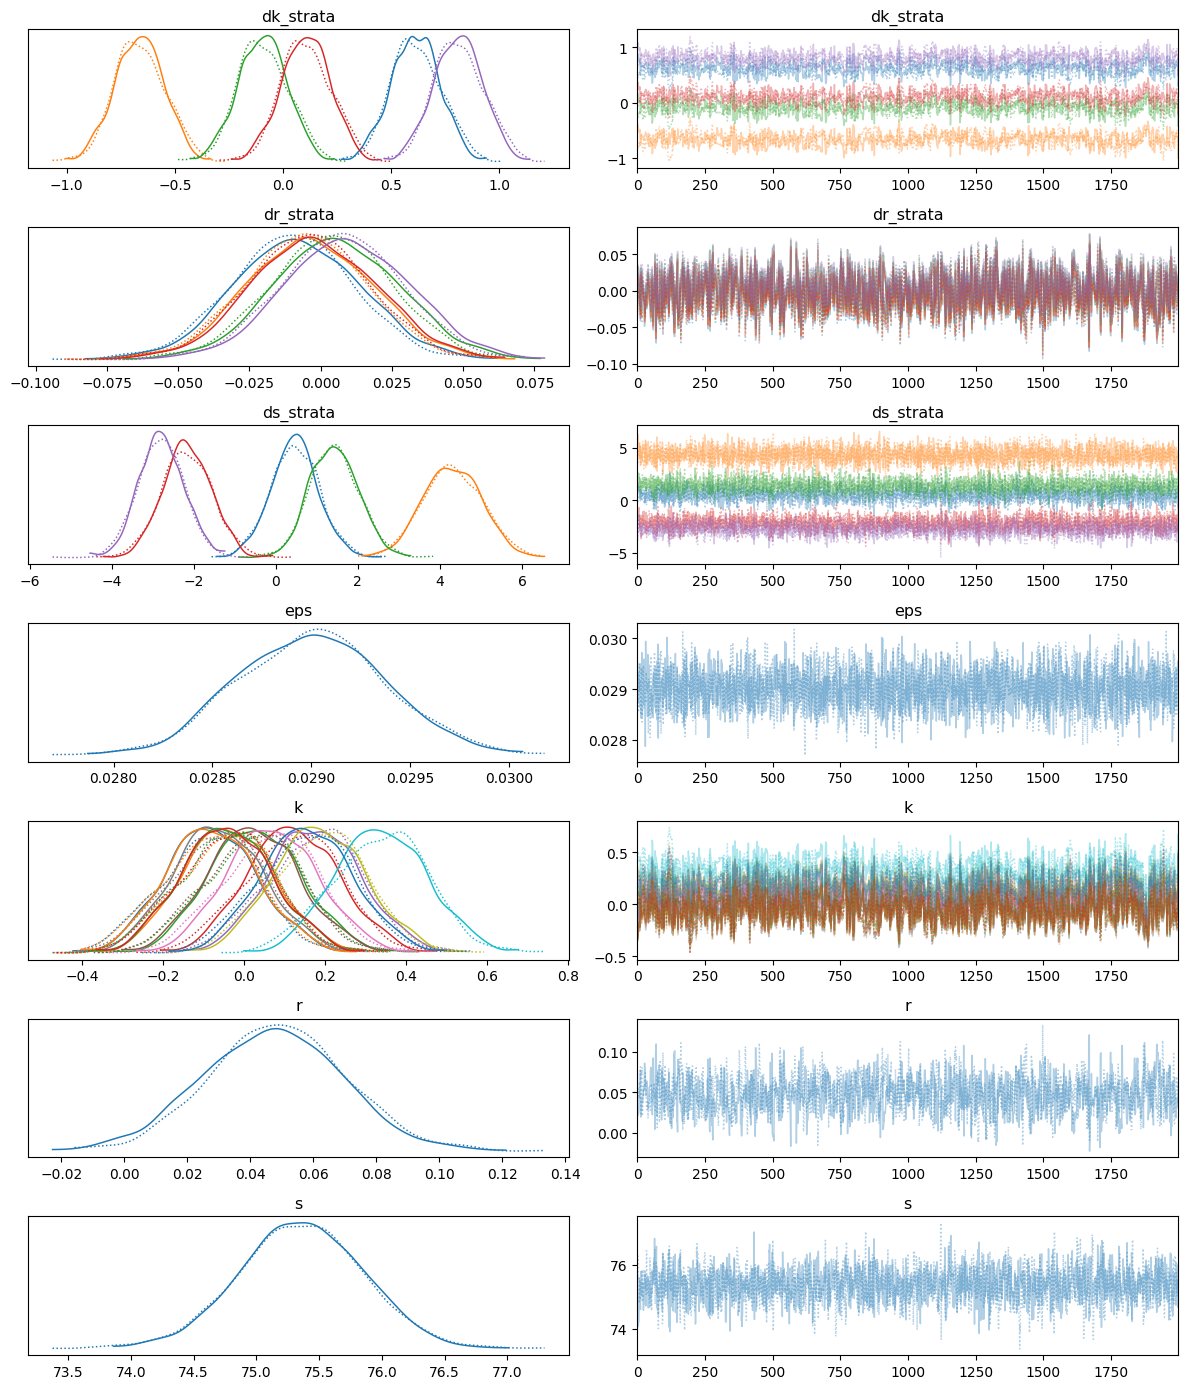

In [10]:
axes = az.plot_trace(trace, kind="trace")
plt.tight_layout()

TODO: Discuss convergence